## Table of Contents

### 1. Use a trained Autoencoder model to extract features from the images
> #### 1.1 Prepare data
> #### 1.2 Create autoencoder model and train it
> #### 1.3 Extract features from images using the trained encoder
### 2. Cluster images on the basis of extracted features
> #### 2.1 Prepare clustering algorithm
> #### 2.2 Get clusters from the features
> #### 2.3 Visualize results

### 1. Use a trained Autoencoder model to extract features from the images

#### 1.1 Prepare data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/MNIST.zip'

Streaming output truncated to the last 5000 lines.
  inflating: MNIST/images/10054.png  
  inflating: MNIST/images/10146.png  
  inflating: MNIST/images/10149.png  
  inflating: MNIST/images/10156.png  
  inflating: MNIST/images/10171.png  
  inflating: MNIST/images/10188.png  
  inflating: MNIST/images/1019.png   
  inflating: MNIST/images/10206.png  
  inflating: MNIST/images/10238.png  
  inflating: MNIST/images/10279.png  
  inflating: MNIST/images/10295.png  
  inflating: MNIST/images/10359.png  
  inflating: MNIST/images/10401.png  
  inflating: MNIST/images/10426.png  
  inflating: MNIST/images/10527.png  
  inflating: MNIST/images/10543.png  
  inflating: MNIST/images/10553.png  
  inflating: MNIST/images/10572.png  
  inflating: MNIST/images/10778.png  
  inflating: MNIST/images/10805.png  
  inflating: MNIST/images/10826.png  
  inflating: MNIST/images/10829.png  
  inflating: MNIST/images/10859.png  
  inflating: MNIST/images/1086.png   
  inflating: MNIST/images/10862.png  

In [0]:
# import libraries and modules
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

import torch
from torch.optim import Adam
from torch.nn import Module, Sequential, Linear, ReLU, Sigmoid, MSELoss

In [0]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [0]:
# define directory path
data_dir = os.path.join(os.path.abspath('.'), 'MNIST')

In [6]:
# read data files
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

df.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


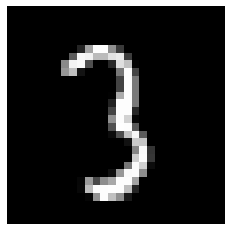

In [7]:
# plot sample image
## choose a random image
img_name = rng.choice(df.filename)
filepath = os.path.join(data_dir, 'images', img_name)

## read image
img = imread(filepath, as_gray=True)

## show image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# print shape of image
img.shape

(28, 28)

In [0]:
# read images and store them as numpy arrays

## read train images
temp = []
for img_name in df.filename:
    image_path = os.path.join(data_dir, 'images', img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)
    
## store them in train_x
train_x = np.stack(temp)
train_x = train_x.reshape(-1, 784).astype('float32')

In [10]:
# print shape of train_x array
train_x.shape

(49000, 784)

In [11]:
# print minimum and maximum values of train_x array
train_x.min(), train_x.max()

(0.0, 1.0)

In [0]:
#converting array into tensors
train_x  = torch.FloatTensor(train_x)

In [0]:
# split data into training and validation
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]

#### 1.2 Create autoencoder model and train it

In [0]:
# Define AutoEncoder architecture

# Input

# Encoder
#   Linear(2000, 'relu')
#   Linear(500, 'relu')
#   Linear(100, 'relu')
#   Linear(10, 'linear')

# Decoder
#   Linear(100, 'relu')
#   Linear(500, 'relu')
#   Linear(784, 'sigmoid')


class Net(Module):   
  def __init__(self):

      super(Net, self).__init__()

      #define the encoder block   
      self.encoder=Sequential(
           
           Linear(28*28, 2000),
           ReLU(),

           Linear(2000, 500),
           ReLU(),

           Linear(500, 100),
           ReLU(),

           Linear(100, 10)
        
       )
      
      #define the decoder block   
      self.decoder=Sequential(
           
           Linear(10, 100),
           ReLU(),

           Linear(100, 500),
           ReLU(),

           Linear(500, 28*28),
           Sigmoid()

       )
  
  #Defining the forward pass    
  def forward(self, x):
    
    #encoder block
    x = self.encoder(x)
        
    #decoder block
    x = self.decoder(x)
    
    return x

In [0]:
#define the model
autoencoder = Net()

In [16]:
#layers used in the model
print(autoencoder)

Net(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
#pass an sample input to the model

#deactivates autograd
with torch.no_grad():
  pred = autoencoder(train_x[:1])
  
print(pred.shape)

torch.Size([1, 784])


In [18]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [0]:
#push the model to the respective device
autoencoder = autoencoder.to(device)

In [0]:
#define optimizer and loss
optimizer = Adam(autoencoder.parameters())
criterion = MSELoss()

In [0]:
# define training function
def train(X,y,batch_size):

  #activate training phase
  autoencoder.train()
  
  #initialization
  epoch_loss=0
  no_of_batches=0

  #randomly create indices
  indices= torch.randperm(len(X))

  #loading in batches
  for i in range(0,len(indices),batch_size):

    #indices for a batch
    ind = indices[i:i+batch_size]

    #batch  
    batch_x=X[ind]
    batch_y=y[ind]
    
    #push to respective device
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    #clear gradients
    optimizer.zero_grad()
          
    #forward pass
    outputs = autoencoder(batch_x)

    #converting to a 1 dimensional tensor
    outputs = outputs.squeeze()

    #calculate loss 
    loss = criterion(outputs, batch_y)

    #Backward pass
    loss.backward()
    
    #Update weights
    optimizer.step()

    #Keep track of the loss and accuracy of a epoch
    epoch_loss = epoch_loss + loss.item()

    #No. of batches
    no_of_batches = no_of_batches+1

  return epoch_loss/no_of_batches

In [0]:
def evaluate(X,y,batch_size):

  #deactivate training phase
  autoencoder.eval()

  #initialization
  epoch_loss=0
  no_of_batches = 0

  #randomly create indices
  indices= torch.randperm(len(X))

  #deactivates autograd
  with torch.no_grad():
    
    #loading in batches
    for i in range(0,len(indices),batch_size):

      #indices for a batch
      ind = indices[i:i+batch_size]

      #batch  
      batch_x=X[ind]
      batch_y=y[ind]

      #push to respective device
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
        
      #Forward pass
      outputs = autoencoder(batch_x)

      #converting the output to 1 Dimensional tensor
      outputs = outputs.squeeze()

      # Calculate loss and accuracy
      loss = criterion(outputs, batch_y)
      
      #keep track of loss and accuracy of an epoch
      epoch_loss = epoch_loss + loss.item()

      #no. of batches
      no_of_batches = no_of_batches + 1

    return epoch_loss/no_of_batches

In [0]:
# define prediction function
def predict(X,batch_size):
  
  #deactivate training phase
  autoencoder.eval()

  # initialization 
  predictions = []

  # create indices
  indices = torch.arange(len(X))

  #deactivates autograd
  with torch.no_grad():
      
      for i in range(0, len(X), batch_size):
        
        #indices for a batch
        ind = indices[i:i+batch_size]

        # batch
        batch_x = X[ind]

        #push to respective device
        batch_x = batch_x.to(device)

        #Forward pass
        outputs = autoencoder(batch_x)

        #converting the output to 1 Dimensional tensor
        outputs = outputs.squeeze()

        # convert to numpy array
        prediction = outputs.data.cpu().numpy()
        predictions.append(prediction)
    
  # convert to single numpy array
  predictions = np.concatenate(predictions, axis=0)
    
  return predictions

In [0]:
# define prediction function
def predict_encoder(X,batch_size):
  
  #deactivate training phase
  autoencoder.eval()

  # initialization 
  predictions = []

  # create indices
  indices = torch.arange(len(X))

  #deactivates autograd
  with torch.no_grad():
      
      for i in range(0, len(X), batch_size):
        
        #indices for a batch
        ind = indices[i:i+batch_size]

        # batch
        batch_x = X[ind]

        #push to respective device
        batch_x = batch_x.to(device)

        #Forward pass
        outputs = autoencoder.encoder(batch_x)

        #converting the output to 1 Dimensional tensor
        outputs = outputs.squeeze()

        # convert to numpy array
        prediction = outputs.data.cpu().numpy()
        predictions.append(prediction)
    
  # convert to single numpy array
  predictions = np.concatenate(predictions, axis=0)
    
  return predictions

In [25]:
N_EPOCHS = 30
batch_size = 32

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss = train(train_x, train_x, batch_size)
    
    #evaluate the model
    valid_loss = evaluate(val_x, val_x, batch_size)

    print('\nEpoch :',epoch,
          'Training loss:',round(train_loss,4),
          '\tValidation loss:',round(valid_loss,4) )

    #save the best model
    if best_valid_loss >= valid_loss:
        best_valid_loss = valid_loss
        torch.save(autoencoder.state_dict(), 'saved_weights.pt') 
        print("----------------------------------------------------Saved best model------------------------------------------------------------------")   


Epoch : 0 Training loss: 0.0371 	Validation loss: 0.0241
----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 1 Training loss: 0.0212 	Validation loss: 0.0189
----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 2 Training loss: 0.0175 	Validation loss: 0.0169
----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 3 Training loss: 0.016 	Validation loss: 0.0159
----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 4 Training loss: 0.015 	Validation loss: 0.0153
----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 5 Training loss: 0.0143 	Val

In [26]:
#load weights of best model
path='saved_weights.pt'
autoencoder.load_state_dict(torch.load(path))

<All keys matched successfully>

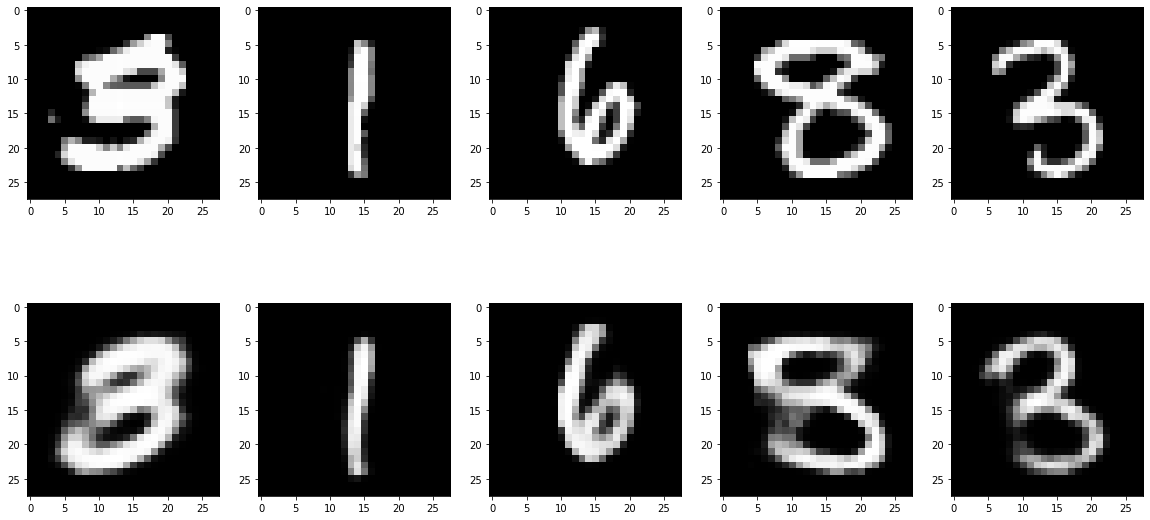

In [27]:
#check output of autoencoder model
#predict probabilities
pred = predict(val_x, batch_size)

true = val_x.reshape(-1,28,28)
pred = pred.reshape(-1,28,28)

#Glance at the images
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(20,10))

plots = [axes[0][i].imshow(true[i],cmap='gray') for i in range(5)]  
plots = [axes[1][i].imshow(pred[i],cmap='gray') for i in range(5)]  

In [28]:
autoencoder.encoder

Sequential(
  (0): Linear(in_features=784, out_features=2000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2000, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
# extract features from encoder
pred_auto_train = predict_encoder(train_x, batch_size)
pred_auto = predict_encoder(val_x, batch_size)

In [30]:
pred_auto[0]

array([ 2.703292  ,  4.459463  , -0.97854125, -5.475096  ,  3.839936  ,
       -2.4911964 , -0.25473857, -1.2787898 , -3.3740246 , -4.815878  ],
      dtype=float32)

In [0]:
# train a kmeans clustering model to categorize the features of images

## define kmeans model
km = KMeans(n_jobs=-1, n_clusters=10)

In [0]:
## train kmeans model on features extracted from training data
km.fit(pred_auto_train)

## get predictions from kmeans model on features extracted from validation data
pred = km.predict(pred_auto)

This image belongs to Cluster 4


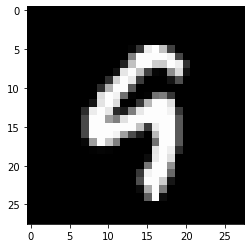

In [33]:
# check the output of kmeans model
index = rng.choice(range(len(val_x)))

print("This image belongs to Cluster " + str(pred[index]))
plt.imshow(val_x[index].reshape((28, 28)), cmap='gray')
plt.show()

In [34]:
# get actual classes
train_y = df.label.values
train_y, val_y = train_y[:split_size], train_y[split_size:]

# compare clusters with actual classes
temp = pd.DataFrame({"val_y":val_y, "cluster_name":pred})
temp[temp.cluster_name == 1].head()

,val_y,cluster_name
20,9,1
56,4,1
59,4,1
66,4,1
78,9,1


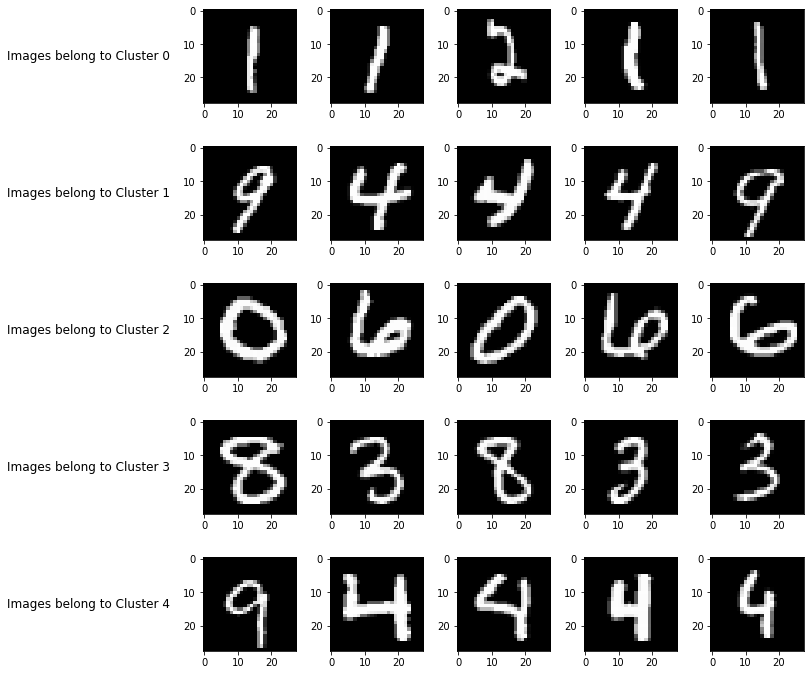

In [35]:
# visualize multiple images of cluster
## create plot
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10))

## set row name on the basis of clusters
rows = ['Images belong to Cluster {}'.format(row) for row in ['0', '1', '2', '3', '4']]
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

## set images in subplots
for i in range(5):
  temp2 = temp[temp.cluster_name == i].head() 
  for j, img in enumerate(val_x[temp2.index.values]):
    img = img.reshape((28, 28))
    axes[i][j].imshow(img, cmap='gray')

## adjust plot with respect to the column title
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

## show plot
plt.show()

In [36]:
# print score of overall model
normalized_mutual_info_score(pred, val_y)

0.6260946631960705